In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler
import cv2
import albumentations as A
import pandas as pd
from albumentations.pytorch import ToTensorV2

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
    device = 'cuda'
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [4]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 2e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
TEST_BATCH_SIZE = 128
NUM_EPOCHS = 50
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = False

In [5]:
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=.1),
        A.VerticalFlip(p=.5),
        A.Normalize(
            mean=[0., 0., 0.],
            std=[1., 1., 1.],
            max_pixel_value=255.,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0., 0., 0.],
            std=[1., 1., 1.],
            max_pixel_value=255.,
        ),
        ToTensorV2(),
    ]
)

In [6]:
img_transform = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])


mask_transform = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

In [7]:
import zipfile

with zipfile.ZipFile("../input/carvana-image-masking-challenge/train.zip","r") as zip_ref:
    zip_ref.extractall(".")

with zipfile.ZipFile("../input/carvana-image-masking-challenge/train_masks.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [8]:
train_csv_zip = '../input/carvana-image-masking-challenge/train_masks.csv.zip'

with zipfile.ZipFile(train_csv_zip, 'r') as zip_:
    zip_.extractall(".")

In [9]:
#Let's make a dataframe that maps the car_id to the image_path
img_id_list = []
path_list = []
for dir_name, _, file_names in os.walk('./train'):
    for file_name in file_names:
        path = os.path.join(dir_name, file_name)
        path_list.append(path)
        img_id = file_name.split('.')[0]
        img_id_list.append(img_id)

dictionary = {'id':img_id_list, 'img_path':path_list}
df = pd.DataFrame(data = dictionary)
df = df.set_index('id')

In [10]:
#Let's make another dataframe that maps the car_ids to the mask_path
img_id_list = []
path_list = []
for dir_name, _, file_names in os.walk('./train_masks'):
    for file_name in file_names:
        path = os.path.join(dir_name, file_name)
        path_list.append(path)
        img_id = file_name.split('_mask')[0]
        img_id_list.append(img_id)

dictionary = {'id':img_id_list, 'mask_path':path_list}
mask_df = pd.DataFrame(data = dictionary)
mask_df = mask_df.set_index('id')

In [11]:
#Now, let's add the mask path's to the same dataframe whci halready has the car_ids and image_paths
df['mask_path'] = mask_df['mask_path']
df

,img_path,mask_path
id,,
d46244bc42ed_14,./train/d46244bc42ed_14.jpg,./train_masks/d46244bc42ed_14_mask.gif
21a7e6726ee3_13,./train/21a7e6726ee3_13.jpg,./train_masks/21a7e6726ee3_13_mask.gif
0795e132d090_07,./train/0795e132d090_07.jpg,./train_masks/0795e132d090_07_mask.gif
2a4a8964ebf3_15,./train/2a4a8964ebf3_15.jpg,./train_masks/2a4a8964ebf3_15_mask.gif
a2df64508b97_11,./train/a2df64508b97_11.jpg,./train_masks/a2df64508b97_11_mask.gif
...,...,...
85bc655a7523_08,./train/85bc655a7523_08.jpg,./train_masks/85bc655a7523_08_mask.gif
2f39abb12388_14,./train/2f39abb12388_14.jpg,./train_masks/2f39abb12388_14_mask.gif
3627b6f4c16d_04,./train/3627b6f4c16d_04.jpg,./train_masks/3627b6f4c16d_04_mask.gif


In [12]:
class U_NetDataset(Dataset):
    def __init__(self,df,transform = None):
        self.df = df 
        self.transform = transform
        self.images = df['img_path'].tolist()
        self.masks = df['mask_path'].tolist()
        assert len(self.images) == len(self.masks), 'number of images and masks are not equal'
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        #The Albumentations library requires images and masks to be a numpy array
        img = np.array(Image.open(image_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'),dtype = np.float32) #Convert to grayscale
        mask[mask == 255.0] = 1.0 #Since our loss function is going to have a sigmoid, we'll convert our mask into 1s and 0s
        #The Albumentations library requires this format
        augmentations = self.transform(image = img, mask = mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
                
        return image,mask

In [13]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=.1)

train_dataset = U_NetDataset(train_df, train_transforms)
print(len(train_dataset))
val_dataset = U_NetDataset(val_df, val_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY)

4579


In [14]:
# Sanity Check
dataiter = iter(train_loader)
images, masks = dataiter.next()

print(images.shape)
print(masks.shape)

torch.Size([32, 3, 160, 240])
torch.Size([32, 160, 240])


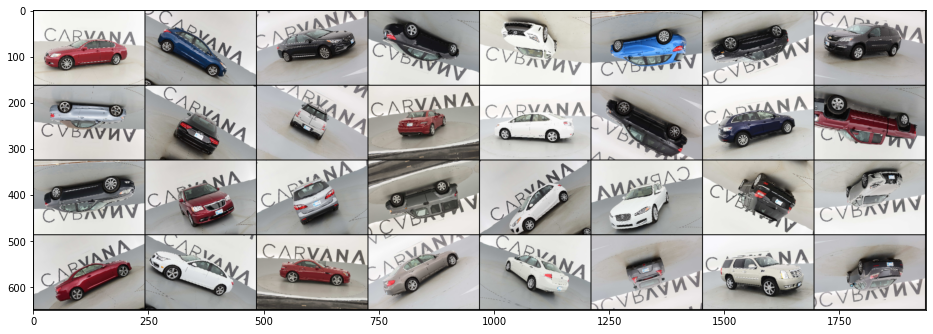

In [15]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,32))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

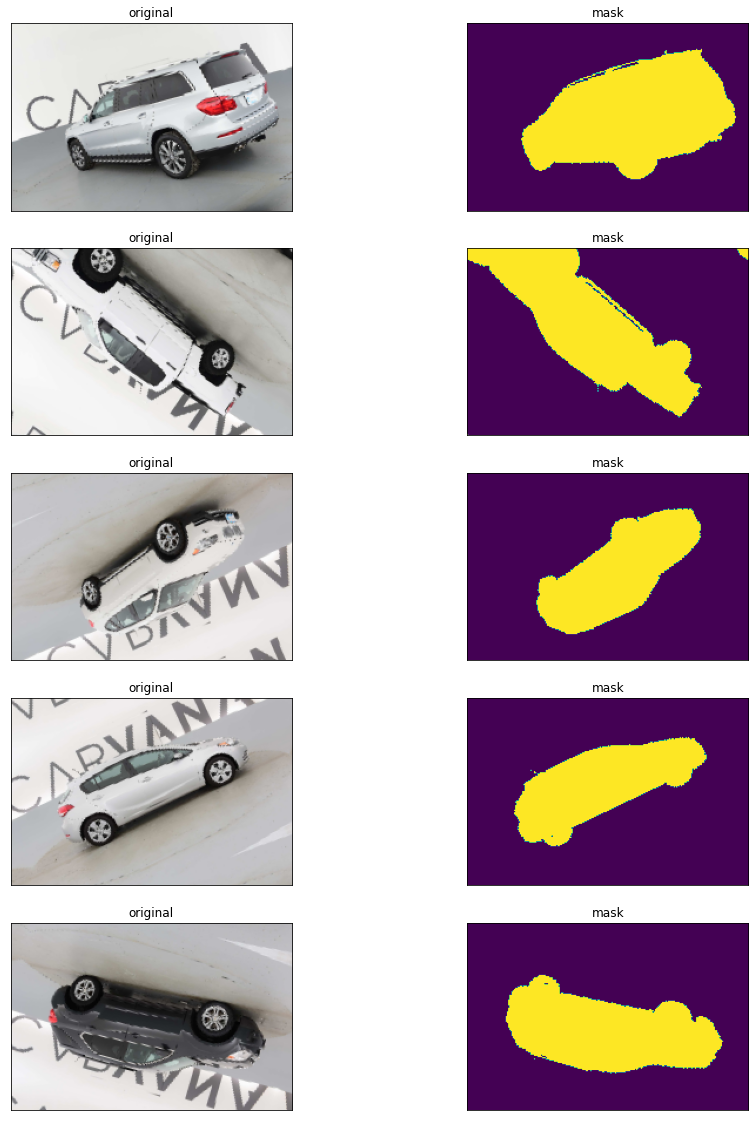

In [16]:
rand_idx = np.random.randint(len(train_dataset), size=5)

fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Plot the images
for i, idx in enumerate(rand_idx):
    img, mask = train_dataset[idx]
    img = img.numpy()
    mask = mask.numpy()
    # in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
    img = img.transpose(1, 2, 0)
    
    ax_img = axes[i][0]
    ax_mask = axes[i][1]
    
    ax_img.imshow(img)
    ax_img.get_xaxis().set_visible(False)
    ax_img.get_yaxis().set_visible(False)
    ax_img.set_title('original')
    
    ax_mask.imshow(mask)
    ax_mask.get_xaxis().set_visible(False)
    ax_mask.get_yaxis().set_visible(False)
    ax_mask.set_title('mask')

In [17]:
#Model
#We are going to make a couple ofsmall changes in the implementation, compared to the original unet paper, we are going to use padded cpnvolution and not downsize and we'll use BatchNorm.
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False), #Same padding, bias is False because we are using BatchNorm
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64,128,256,512]):
        super(UNET, self).__init__()
        #Define two lists to store all the Conv layers and also define a pooling layer
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList() 
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #Define downsampling
        for feature in features:
            self.downs.append(DoubleConv(in_channels,feature)),
            in_channels = feature
                
        #Define Upsampling
        for feature in reversed(features):
            #Set kernel_size and stride to double the image_height and image_width
            self.ups.append(
            nn.ConvTranspose2d(feature*2,feature,kernel_size = 2,stride = 2)
            )
            self.ups.append(DoubleConv(feature*2,feature))
        #This is the layer which is at the bottom of the U shape
        self.bottleneck = DoubleConv(features[-1],features[-1]*2)
        #Set kernel_size to maintain the height and width of the image
        self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size = 1)
        
    def forward(self,x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x) #To remember the Conv we need in the skip connections
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
            
        for idx in range(0,len(self.ups),2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            #But what if input image dimensions are not divisible by 2^^4?
            if x.shape != skip_connection.shape:
                x = F.resize(x, size=skip_connection.shape[2:])#The [2:] gets rid of the batch size and number of dim
            
            concat_skip = torch.cat((skip_connection, x),dim = 1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

In [26]:
#Sanity Check
x = torch.randn((64,3,160,160))
m = UNET(in_channels = 3,out_channels = 1)
preds = m(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape

torch.Size([64, 1, 160, 160])
torch.Size([64, 3, 160, 160])


AssertionError: 

In [19]:
model = UNET(in_channels = 3,out_channels = 1).to(device)
model

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [20]:
from tqdm import tqdm
def train(loader, model, optimizer, criterion, scaler):
    loop = tqdm(loader) #For the progress bar
    
    for idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.float().unsqueeze(1).to(device)
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss = loss.item())
        

In [21]:
def dice_score(loader, model, device = "cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device)
            y=y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds>0.5).float()
            num_correct += (preds == y).sum()
            num_pixels +=torch.numel(preds)
            dice_score += (2*(preds*y).sum())/((preds+y).sum()+1e-8)
        print(f"Got{num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")  
        print(f"Dice score : {dice_score/len(loader)}")
        model.train()
    

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [23]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    print(f"epoch:{epoch}/{NUM_EPOCHS}")
    train(train_loader, model, optimizer, criterion, scaler)
    dice_score(val_loader, model, device = "cuda")

  0%|          | 0/144 [00:00<?, ?it/s]

epoch:0/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19131328/19545600 with acc 97.88
Dice score : 0.9505172371864319
epoch:1/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19368054/19545600 with acc 99.09
Dice score : 0.9784526824951172
epoch:2/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19405521/19545600 with acc 99.28
Dice score : 0.9828395843505859
epoch:3/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19423773/19545600 with acc 99.38
Dice score : 0.9850993156433105
epoch:4/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19420071/19545600 with acc 99.36
Dice score : 0.9846107959747314
epoch:5/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19432039/19545600 with acc 99.42
Dice score : 0.9860888719558716
epoch:6/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19434945/19545600 with acc 99.43
Dice score : 0.986427903175354
epoch:7/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19441572/19545600 with acc 99.47
Dice score : 0.9872561693191528
epoch:8/10


  0%|          | 0/144 [00:00<?, ?it/s]

Got19421662/19545600 with acc 99.37
Dice score : 0.9848910570144653
epoch:9/10


100%|██████████| 144/144 [08:58<00:00,  3.74s/it, loss=0.029] 


Got19442866/19545600 with acc 99.47
Dice score : 0.987429141998291


In [ ]:
class Test(Dataset):
    def __init__(self,df,transform = None):
        self.df = df 
        self.transform = transform
        self.images = df['img_path'].tolist()
        #self.masks = df['mask_path'].tolist()
        #assert len(self.images) == len(self.masks), 'number of images and masks are not equal'
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image_path = self.images[idx]
        #mask_path = self.masks[idx]
        #The Albumentations library requires images and masks to be a numpy array
        img = np.array(Image.open(image_path).convert('RGB'))
        #mask = np.array(Image.open(mask_path).convert('L'),dtype = np.float32) #Convert to grayscale
        #mask[mask == 255.0] = 1.0 #Since our loss function is going to have a sigmoid, we'll convert our mask into 1s and 0s
        #The Albumentations library requires this format
        augmentations = self.transform(image = img, mask = mask)
        image = augmentations["image"]
        #mask = augmentations["mask"]
                
        return image

In [ ]:
with zipfile.ZipFile("../input/carvana-image-masking-challenge/test.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [ ]:
img_id_list = []
path_list = []
for dir_name, _, file_names in os.walk('./test'):
    for file_name in file_names:
        path = os.path.join(dir_name, file_name)
        path_list.append(path)
        img_id = file_name.split('.')[0]
        img_id_list.append(img_id)

tdictionary = {'id':img_id_list, 'img_path':path_list}
dft = pd.DataFrame(data = tdictionary)
dft = dft.set_index('id')

In [ ]:
test_ds = Test(dft, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=PIN_MEMORY)

In [ ]:
for i in test_loader:
    pred = model(i)
    dice_score(test_loader, model, device = "cuda")

In [ ]:
rand_idx = np.random.randint(len(test_ds), size=5)

fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Plot the images
for i, idx in enumerate(rand_idx):
    img = test_ds[idx]
    mask = model(test_ds[idx])
    img = img.numpy()
    mask = mask.numpy()
    
    # in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
    img = img.transpose(1, 2, 0)
    
    ax_img = axes[i][0]
    ax_mask = axes[i][1]
    
    ax_img.imshow(img)
    ax_img.get_xaxis().set_visible(False)
    ax_img.get_yaxis().set_visible(False)
    ax_img.set_title('original')
    
    ax_mask.imshow(mask)
    ax_mask.get_xaxis().set_visible(False)
    ax_mask.get_yaxis().set_visible(False)
    ax_mask.set_title('mask')